# Iowa Housing Pricing: Modeling & Analysis

### Contents


In [15]:
# Import packages etc.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Import data
x_train = pd.read_csv('ITrain_DSet.csv').drop(['Unnamed: 0'], axis=1)
y_train = pd.read_csv('ITrain_Test.csv').drop(['Unnamed: 0'], axis=1)
x_test = pd.read_csv('ITTest_DSet.csv').drop(['Unnamed: 0'], axis=1)
y_test = pd.read_csv('ITTest_Test.csv').drop(['Unnamed: 0'], axis=1)
sample_result = pd.read_csv('sample_submission.csv')
testset = pd.read_csv('test.csv')


In [16]:
for dat in [x_train, y_train, x_test, y_test]:
    print(dat.shape)

(1168, 265)
(1168, 1)
(292, 265)
(292, 1)


# Processing & Scaling

In [17]:
from sklearn.preprocessing import StandardScaler
import pickle

# scale data
scale = StandardScaler()
x_train = pd.DataFrame(scale.fit_transform(x_train),   # Fit & Transform Train
                      columns=x_train.columns.to_list())
x_test = pd.DataFrame(scale.transform(x_test),         # Transform Test Per Train
                     columns=x_test.columns.to_list())
pickle.dump(scale, open('./scale.pkl', 'wb'))          # Save Scale Pickle

In [18]:
from sklearn import linear_model, svm, ensemble, model_selection
import xgboost as xgb

##################################
### Prepare Modeling Materials ###
##################################

# Define Range of Models
ridge = linear_model.Ridge()
svr = svm.SVR()
randomForest = ensemble.RandomForestRegressor(n_jobs = -2,random_state = 430)
gradientBoost = ensemble.GradientBoostingRegressor(random_state = 430)
xgForest = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
xgBooster = xgb.XGBRegressor(n_jobs = -2, random_state = 430)

# Collect Models
models = [ridge, svr, randomForest, gradientBoost,
         xgForest, xgBooster]

# Make results df
resul = pd.DataFrame(columns = ['Model', 'Ridge', 'SVR', 'RForest', 'GBoost', 'XGRForest', 'XGBoost'])
resul.set_index("Model", inplace = True)
resul.loc['StandardTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['StandardTest'] = [0, 0, 0, 0, 0, 0]
resul.loc['GSTunedTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['GSTunedTest'] = [0, 0, 0, 0, 0, 0]

##########################################
### Build & Test Models w/o GridSearch ###
##########################################

col = 0
for model in models:
    model.fit(x_train, y_train['SalePrice'])
    resul.iloc[0, col] = model.score(x_train, y_train['SalePrice'])
    resul.iloc[1, col] = model.score(x_test, y_test['SalePrice'])
    col += 1

resul.head()

,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GSTunedTrain,0,0,0,0,0,0
GSTunedTest,0,0,0,0,0,0


# Train Initial Regressive Models
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)

In order to attempt a broad analysis of our data, we will include classical, sklearn regression techniques, ranging from **Ridge & Lasso regressions** to svm's **Support Vector Regression**, and further to ensemble's **Random Forest Regressor** as well as **Gradient Boosting Regressor**.

We will complement our analysis with the popular *XGBoost* **Random Forest Regressor** and **Gradient Boosting Regressor** to compare their results with those of the native sklearn package.

In [19]:
from sklearn import linear_model, svm, ensemble
import xgboost as xgb

#####################
### Define Models ###
#####################

ridge = linear_model.Ridge()
svr = svm.SVR()
randomForest = ensemble.RandomForestRegressor(n_jobs = -2,random_state = 430)
gradientBoost = ensemble.GradientBoostingRegressor(random_state = 430)
xgForest = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
xgBooster = xgb.XGBRegressor(n_jobs = -2, random_state = 430)

models = [ridge, svr, randomForest, gradientBoost, xgForest, xgBooster]

# Make results df
resul = pd.DataFrame(columns = ['Model', 'Ridge', 'SVR', 'RForest', 'GBoost', 'XGRForest', 'XGBoost'])
resul.set_index("Model", inplace = True)
resul.loc['StandardTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['StandardTest'] = [0, 0, 0, 0, 0, 0]
resul.loc['GridSearchCVTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['GridSearchCVTest'] = [0, 0, 0, 0, 0, 0]

##########################################
### Build & Test Models w/o GridSearch ###
##########################################

col = 0
for model in models:
    model.fit(x_train, y_train['SalePrice'])
    resul.iloc[0, col] = model.score(x_train, y_train['SalePrice'])
    resul.iloc[1, col] = model.score(x_test, y_test['SalePrice'])
    col += 1

resul.head()

,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GridSearchCVTrain,0,0,0,0,0,0
GridSearchCVTest,0,0,0,0,0,0


# Grid Searches
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [6]:
############################
### Pickling for Project ###
############################

# pickle.dump(gs_ridge, open(f'./gsridge.pkl', 'wb'))
# pickle.dump(gs_svr, open(f'./gssvr.pkl', 'wb'))
# pickle.dump(gs_randomForest, open(f'./gsrforest.pkl', 'wb'))
# pickle.dump(gs_gradientBoost, open(f'./gsgradient.pkl', 'wb'))
# pickle.dump(gs_xgForest, open(f'./gsxgforest.pkl', 'wb'))
# pickle.dump(gs_xgBooster, open(f'./gsxgbooster.pkl', 'wb'))

In [22]:
###############################
### Import Choicest Pickles ###
###############################

gs_ridge = pickle.load(open('./gsridge.pkl', 'rb'))
gs_svr = pickle.load(open('./gssvr.pkl', 'rb'))
gs_randomForest = pickle.load(open('./gsrforest.pkl', 'rb'))
gs_gradientBoost = pickle.load(open('./gsgradient.pkl', 'rb'))
# gs_xgForest = pickle.load(open('./gs_xgforest2.pkl', 'rb'))
# gs_xgBooster = pickle.load(open('./gs_xgbooster2.pkl', 'rb'))


In [23]:
###################
### Ridge Model ###
###################

# import new toys
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import model_selection

# reset items
ridge2 = linear_model.Ridge()
pca = PCA(random_state=430)

# pipe & search
ridge_grid = {'pca__n_components': range(50, x_train.shape[1]),
             'model__alpha': [0.01, 0.1, 1, 10, 100, 1000]}
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', ridge2)])
gs_ridge = model_selection.GridSearchCV(pipeline, ridge_grid, n_jobs=-2, cv=3)
gs_ridge.fit(x_train, y_train['SalePrice'])
print('Ridge Regressor Params: ' + str(gs_ridge.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 0] = gs_ridge.score(x_train, y_train['SalePrice'])
resul.iloc[3, 0] = gs_ridge.score(x_test, y_test['SalePrice'])
resul.head()

Ridge Regressor Params: {'model__alpha': 100, 'pca__n_components': 192}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GridSearchCVTrain,0.904396,0,0,0,0,0
GridSearchCVTest,0.84949,0,0,0,0,0


In [24]:
############################
### Support Vector Model ###
############################

# reset items
svr2 = svm.SVR()
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', svr2)])
svr_grid = {'pca__n_components': range(50, x_train.shape[1]),
           'model__kernel': ['linear', 'poly', 'rbf'],
           'model__C': [0.01, 0.1, 1, 10, 100, 1000],
           'model__gamma': ['scale']}
gs_svr = model_selection.GridSearchCV(pipeline, svr_grid, n_jobs=-2, cv=3)
gs_svr.fit(x_train, y_train['SalePrice'])
print('Ridge Regressor Params: ' + str(gs_svr.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 1] = gs_svr.score(x_train, y_train['SalePrice'])
resul.iloc[3, 1] = gs_svr.score(x_test, y_test['SalePrice'])
resul.head()

Ridge Regressor Params: {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'linear', 'pca__n_components': 206}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GridSearchCVTrain,0.904396,0.850846,0,0,0,0
GridSearchCVTest,0.84949,0.864484,0,0,0,0


In [25]:
###############################
### Random Forest Regressor ###
###############################

randomForest2 = ensemble.RandomForestRegressor(n_jobs = -2,random_state = 430)
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', randomForest2)])
rf_grid = {'pca__n_components': range(50, x_train.shape[1]),
          'model__n_estimators': [500, 750, 1000],
          'model__max_features': ['auto', 'sqrt', 'log2'],
          'model__max_depth': [11, 13, 15, 17, 19, 21]}
gs_randomForest = model_selection.GridSearchCV(pipeline, rf_grid, n_jobs=-2, cv=3)
gs_randomForest.fit(x_train, y_train['SalePrice'])
print('RandomForest Params: ' + str(gs_randomForest.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 2] = gs_randomForest.score(x_train, y_train['SalePrice'])
resul.iloc[3, 2] = gs_randomForest.score(x_test, y_test['SalePrice'])
resul.head()

RandomForest Params: {'model__max_depth': 21, 'model__max_features': 'auto', 'model__n_estimators': 750, 'pca__n_components': 150}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GridSearchCVTrain,0.904396,0.850846,0.972117,0,0,0
GridSearchCVTest,0.84949,0.864484,0.859647,0,0,0


In [26]:
################################
### Gradient Boost Regressor ###
################################

gradientBoost2 = ensemble.GradientBoostingRegressor(random_state = 430)
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', gradientBoost2)])
gb_grid = {'pca__n_components': range(50, x_train.shape[1]),
          'model__learning_rate': [0.01, 0.1, 1],
          'model__n_estimators': [500, 750, 1000],
          'model__max_depth': [2, 3, 4, 5, 6]}
gs_gradientBoost = model_selection.GridSearchCV(pipeline, gb_grid, n_jobs=-2, cv=3)
gs_gradientBoost.fit(x_train, y_train['SalePrice'])
print('GradientBoost Params: ' + str(gs_gradientBoost.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 3] = gs_gradientBoost.score(x_train, y_train['SalePrice'])
resul.iloc[3, 3] = gs_gradientBoost.score(x_test, y_test['SalePrice'])
resul.head()

GradientBoost Params: {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 750, 'pca__n_components': 99}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
GridSearchCVTrain,0.904396,0.850846,0.972117,0.983717,0,0
GridSearchCVTest,0.84949,0.864484,0.859647,0.863327,0,0


In [ ]:
#################################
### XGRandom Forest Regressor ###
#################################

xgForest = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
pca = PCA(random_state=430)

# Pipe & Search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', xgForest)])
xgf_grid = {'pca__n_components': range(50, x_train.shape[1]),
           'model__n_estimators': [500, 750, 1000],
           'model__max_depth': [11, 13, 15, 17, 19, 21],
           'model__gamma': [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1],
           'model__learning_rate': [0.01, 0.1, 1, 10]}
gs_xgForest = model_selection.GridSearchCV(pipeline, xgf_grid, n_jobs=-2, cv=3)
gs_xgForest.fit(x_train, y_train['SalePrice'])
print('XGRandomForest Params: ' + str(gs_xgForest.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 4] = gs_gradienBoost.score(x_train, y_train['SalePrice'])
resul.iloc[3, 4] = gs_gradienBoost.score(x_test, y_test['SalePrice'])
resul.head()

/home/theodore/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
#########################
### XGBoost Regressor ###
#########################

xgBooster = xgb.XGBRegressor(n_jobs = -2, random_state = 430)
pca = PCA(random_state=430)

# Pipe & Search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', xgBooster)])
xgb_grid = {'pca__n_components': range(50, x_train.shape[1]),
           'model__n_estimators': [500, 750, 1000],
           'model__max_depth': [2, 3, 4, 5, 6],
           'model__gamma': [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1],
           'model__learning_rate': [0.01, 0.1, 1]}
gs_xgBooster = model_selection.GridSearchCV(xgBooster, xgb_grid, n_jobs=-2, cv=3)
gs_xgBooster.fit(x_train, y_train['SalePrice'])
print('XGBooster Params: ' + str(gs_xgBooster.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[2, 5] = gs_xgBooster.score(x_train, y_train['SalePrice'])
resul.iloc[3, 5] = gs_xgBooster.score(x_test, y_test['SalePrice'])
resul.head()

# Ascertain Feature Importance

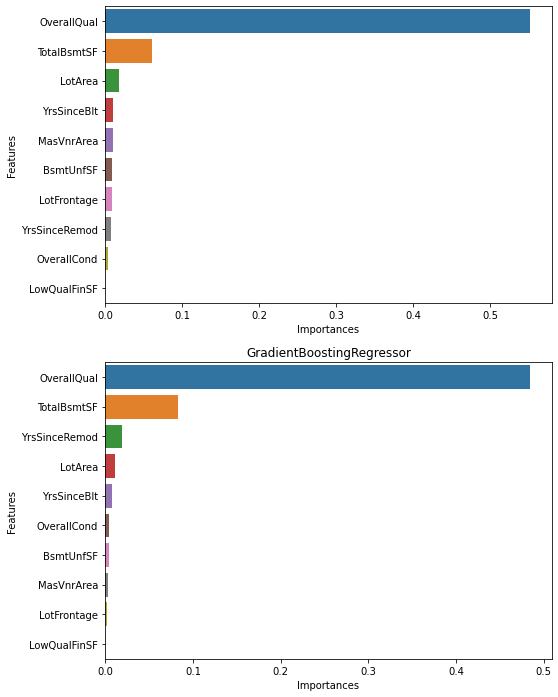

In [27]:
standards = [randomForest, gradientBoost]
fig, axs = plt.subplots(2, 1, figsize=(8, 12))

for ax, standard in zip(axs.flat, standards):
    importance_df = pd.DataFrame({'Features': list(x_train.columns), 
                                  'Importances': list(standard.feature_importances_)}).head(10)
    importance_df.sort_values(by='Importances', ascending=False, inplace=True)
    
    # Plot Everything
    plt.title(str(standard).split('(')[0])
    sns.barplot(x=importance_df['Importances'], y=importance_df['Features'], ax=ax)

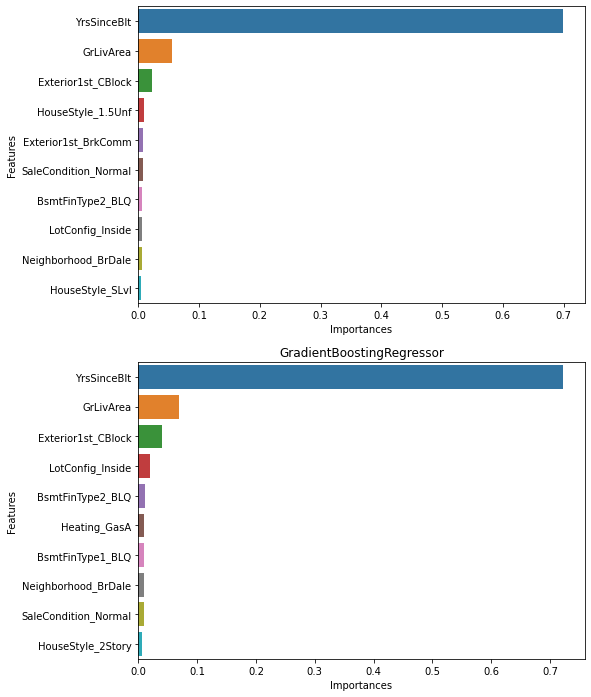

In [28]:
# Group gridsearches & prep plots
grids = [gs_randomForest, gs_gradientBoost]

fig, axs = plt.subplots(2, 1, figsize = (8, 12))

# Find & Plot Feature Importances
for ax, grid in zip(axs.flat, grids):
    bestmodel = grid.best_estimator_.steps[0][1]
    n_pcs = bestmodel.components_.shape[0]
    
    # Apply Pipelined PCA results to get feature names
    most_important = [np.abs(bestmodel.components_[i]).argmax() for i in range(n_pcs)]
    most_important_names = [x_train.columns[most_important[i]] for i in range(n_pcs)]
    
    # Zip & Sort Names and Importances
    zipped_feats = zip(most_important_names, 
                       grid.best_estimator_.steps[1][1].feature_importances_)
    zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
    
    # Get collect best features & importances into importances_df
    bestfeatures, bestimportances = zip(*zipped_feats)
    importance_df = pd.DataFrame({'Features': bestfeatures, 'Importances': bestimportances}).head(10)
    
    # Plot the things
    plt.title(str(grid.estimator.steps[1][1]).split('(')[0])
    sns.barplot(x = importance_df['Importances'], y=importance_df['Features'], ax=ax)

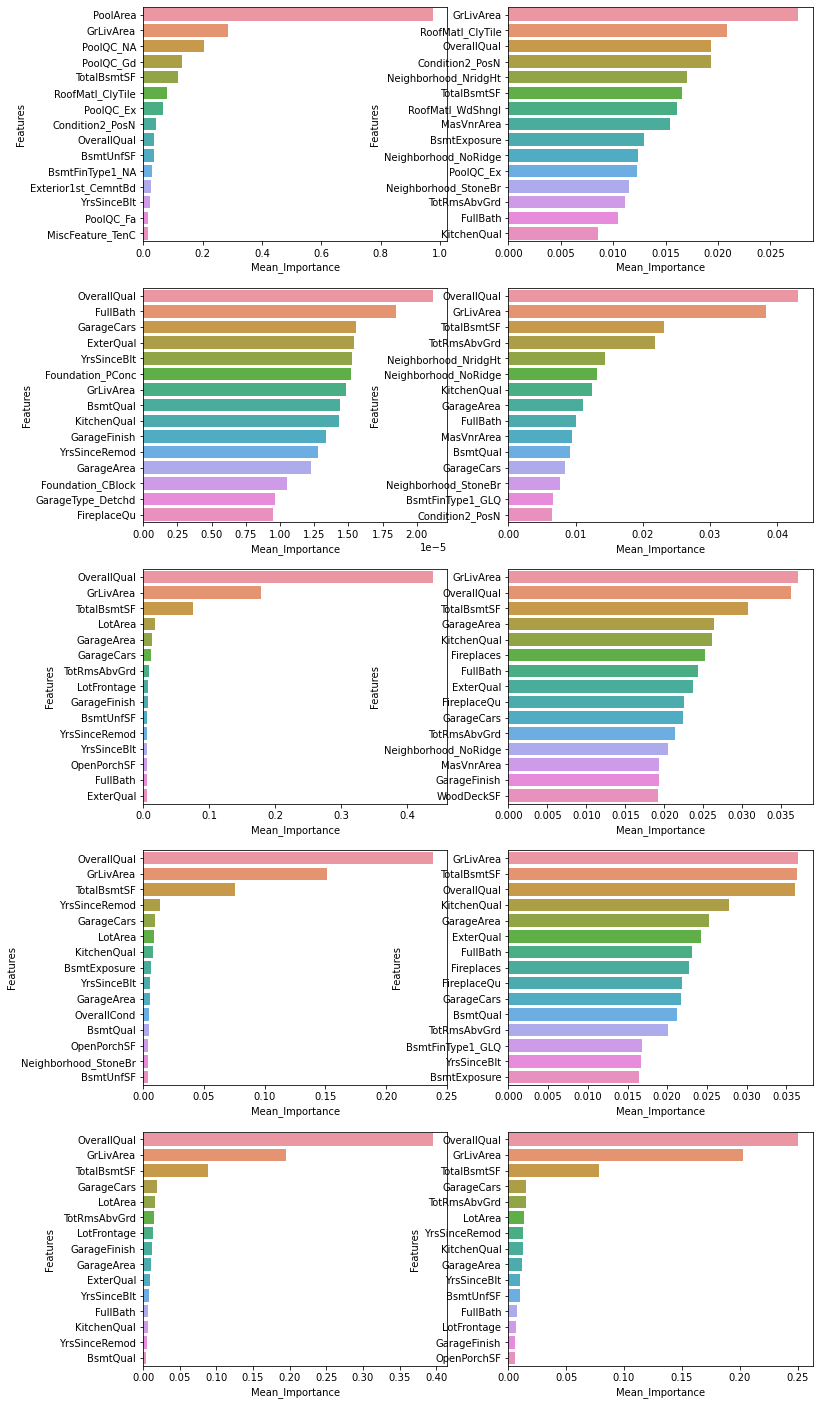

In [31]:
##############################
### Permutation Importance ###
##############################

from sklearn.inspection import permutation_importance

# Collect all predictive models in use
all_models = [ridge, gs_ridge, svr, gs_svr,
             randomForest, gs_randomForest,
             gradientBoost, gs_gradientBoost,
             xgForest, xgBooster]
fig, axs = plt.subplots(5, 2, figsize=(12, 25))

# Prepare Plot Names
model_names = ['Ridge Regressor', 'GS Ridge Regressor',
              'SV Regressor', 'GS SV Regressor',
              'Random Forest', 'GS Random Forest',
              'Gradient Boost', 'GS Gradient Boost',
              'XGRF Regressor', 'XGBooster']
m_idx = 0

# Get Permutation Importance & Plot
for ax, mod in zip(axs.flat, all_models):
    perms = permutation_importance(mod, x_train, y_train['SalePrice'],
                                  n_jobs=-2, random_state=430)
    
    # Generate Permutation DF
    perm_imp = pd.DataFrame({'Mean_Importance': list(perms['importances_mean']),
                            'Features': x_train.columns.to_list()})
    perm_imp = perm_imp.sort_values(by='Mean_Importance', ascending=False).head(15)
    
    # Plot
#     ax.set_title(model_names[m_idx])
    sns.barplot(x=perm_imp['Mean_Importance'], y=perm_imp['Features'], ax=ax)
#     ax.set_yticklabels(ax.get_xticklabels(), rotation=30)
    m_idx += 1

# Make Predictions
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)



In [146]:
testset = pd.read_csv('test.csv')

In [147]:
testset.shape

(1459, 80)

In [148]:
testset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [149]:
testset = data_prep(testset, imputer, ordinal, ohe, scale)
rf_predictions = best_RandomForest.predict(testset)
rf_predictions = pd.DataFrame(rf_predictions).rename(columns = {0:'SalePrice'})

/home/theodore/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [150]:
rf_predictions

,SalePrice
0,122175.074431
1,146125.838607
2,161061.716860
3,167970.228044
4,196198.157914
...,...
1454,79880.487112
1455,87224.141011
1456,147346.763134
1457,108746.269380


In [151]:
# save info
pickle.dump(best_RandomForest, open('./bestRFmodel', 'wb'))
rf_predictions.to_csv('IowaHousingPredictions')